In [68]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")
figsize(10, 10)
import helpers
reload(helpers)

Populating the interactive namespace from numpy and matplotlib


<module 'helpers' from 'helpers.py'>

# PyTorch

"Tensors and Dynamic neural networks in Python with strong GPU acceleration"

- like Matlab or Numpy, but with GPU support
- automatic, dynamic differentiation and gradient descent
- some frameworks for neural networks

# SIMPLE COMPUTATIONS

In [2]:
# simple "tensors" (multidimensional numerical arrays) in Torch

import torch
data = torch.rand(256, 256)
print data


 0.7585  0.4233  0.9100  ...   0.7289  0.6646  0.1777
 0.3566  0.3304  0.8916  ...   0.7445  0.9360  0.1817
 0.0972  0.4338  0.0347  ...   0.1505  0.5047  0.8059
          ...             ⋱             ...          
 0.1872  0.4068  0.9590  ...   0.0278  0.4174  0.5572
 0.8828  0.8159  0.5175  ...   0.9940  0.5365  0.0828
 0.8738  0.7402  0.0544  ...   0.7242  0.6142  0.6929
[torch.FloatTensor of size 256x256]



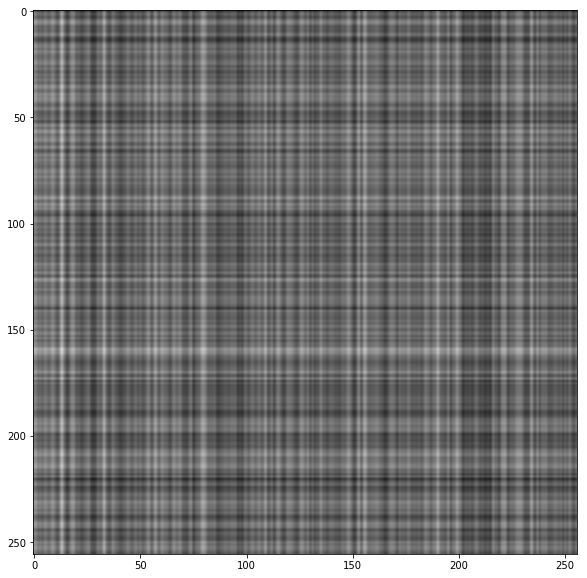

In [74]:
# a pointless GPU computation

data = torch.rand(256, 256).cuda()
out = data
for i in range(100):
    out = torch.mm(data, out)
    out /= out.norm()
imshow(out.cpu().numpy())

# PyTorch 

- standard set of numerical operations
- similar primitives to Numpy, Matlab
- operations run on CPU and GPU
- GPU operations use CUDA, cuDNN, some third party kernels
- direct binding: you call a numerical function, it calls the kernel

# AUTOMATIC DIFFERENTIATION

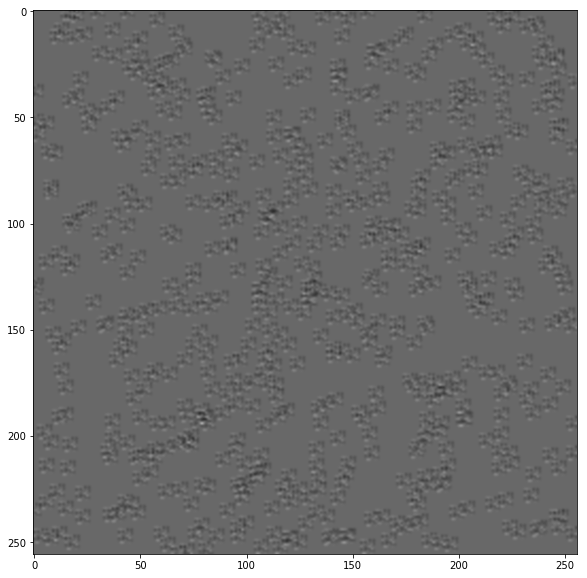

In [109]:
# 2D Convolution with Torch+GPU

import torch.nn.functional as F
from torch.autograd import Variable as Var

x = Var(torch.FloatTensor(image).cuda()[None, None, :, :], requires_grad=True)
y = Var(torch.FloatTensor(target).cuda()[None, None, :, :])

w = Var(torch.randn(1, 1, 7, 7).cuda(), requires_grad=True)

y_predicted = F.conv2d(x, w, padding=3)

imshow(y_predicted.data.cpu().numpy()[0, 0, :, :])

In [110]:
w

Variable containing:
(0 ,0 ,.,.) = 
 -0.1436  0.4706  0.1519 -0.1791  1.5588  2.2371 -0.0818
 -0.9387 -0.9250 -0.7578  0.4523 -0.8329 -0.4651 -0.6797
 -0.1714  1.9886 -1.2107 -0.9201 -1.9193 -0.0443 -1.3506
  0.1477 -0.2152  1.7790  0.3047 -0.8559  0.1907  1.5531
 -1.3204  0.9096 -0.3051 -0.3258 -0.0323  0.5596 -0.4391
 -0.9579 -0.1938 -0.3941  0.3147 -1.8491 -0.3709 -1.8446
 -1.5852 -0.2851 -1.9174  0.5700  0.3954  1.2214  1.0601
[torch.cuda.FloatTensor of size 1x1x7x7 (GPU 0)]

In [111]:
w.grad

In [112]:
# Computing the Error

err = ((y_predicted - y)**2).sum()
print err

err.backward(retain_graph=True)
print w.grad

Variable containing:
 33087.8555
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
(0 ,0 ,.,.) = 
  -252.2952   453.4415    72.7074  -387.6044  1952.0764  2724.3877  -214.3719
 -1328.5555 -1329.7886 -1153.5126   426.6380 -1225.4557  -774.8116  -947.6937
  -282.8864  2426.8501 -1660.4443 -1382.9537 -2599.8635  -220.7002 -1808.4125
   129.4240  -457.6919  2179.3279   232.5813 -1211.3920   120.0664  1944.2300
 -1743.4308  1022.4435  -477.6968  -584.4467   -94.5499   597.6899  -582.8149
 -1269.4990  -391.1533  -575.3254   265.6168 -2516.9517  -663.9385 -2456.0996
 -2123.6221  -550.9259 -2551.9675   495.0281   395.8329  1407.5031  1278.9927
[torch.cuda.FloatTensor of size 1x1x7x7 (GPU 0)]



{139781371025552: 'x', 139781365076664: 'w'}


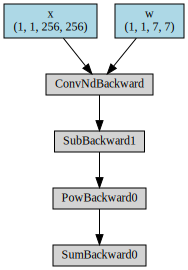

In [113]:
helpers.make_dot(err, dict(w=w, x=x))

# PyTorch Autograd Summary

- Tensors $\rightarrow$ Variables
- PyTorch keeps track of derivatives
- computation graphs can be completely dynamic
- propagate derivatives backwards using `x.backward()`
- access gradients using `x.grad`

# SIMPLE LEARNING

# Learning a Linear Filter

- a `Conv2d` layer is the same as a linear filter
- let's see whether we can learn this using PyTorch
- this uses all the components we need to train more complex models in PyTorch

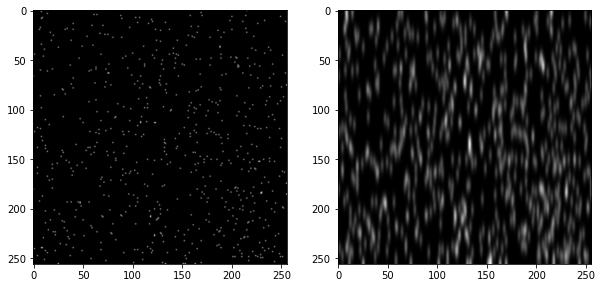

In [114]:
# "training data" is just a simple input/output pair

import scipy.ndimage as ndi
image = 1.0 * (rand(256, 256) > 0.99)
target = ndi.gaussian_filter(image, (5.0, 1.0))
subplot(121); imshow(image); subplot(122); imshow(target)

In [116]:
from torch import nn, optim

# the "model" is just a single convolutional layer
model = nn.Conv2d(1, 1, 17, padding=8)

# the loss is MSE loss
criterion = nn.MSELoss()

# put everything on the GPU
model.cuda()
criterion.cuda();

In [117]:
# train 10000 times

cuinput = Var(torch.FloatTensor(image).cuda())[None, None, :, :]
cutarget = Var(torch.FloatTensor(target).cuda())[None, None, :, :]

for i in range(10000):
    
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    
    cuoutput = model(cuinput)
    
    loss = criterion(cuoutput, cutarget)
    loss.backward()
    
    optimizer.step()

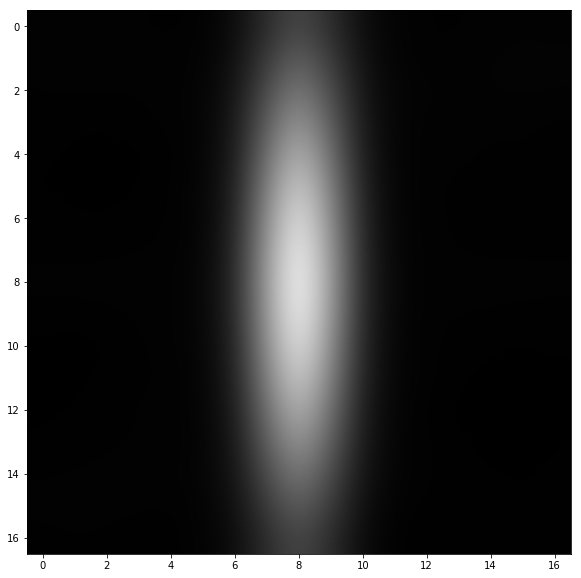

In [119]:
# display the learned kernel
imshow(list(model.parameters())[0].data[0,0].cpu().numpy())

# Torch "Modules" / "Layers"

In [120]:
import torch.functional as F

class Linear(nn.Module):
    def __init__(self, ninput, noutput):
        self.weights = Parameter(torch.randn(noutput, ninput))
    def forward(self, x):
        return F.linear(x, self.weights)
    # NB: no "backward" method needed

# Composition of Torch Layers

In [107]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (4): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
)

# Summary of Torch "Modules" and Training

- training uses modules, criteria, and optimizers
- modules (nn.Module) keep track of parameters and compute in the forward method
- criteria compute the differences between two outputs and return a scalar loss
- optimizers initiate gradient computation and then update the model parameters

# PYTORCH VS OTHERS

# Common Deep Learning Frameworks

Primary:

- TensorFlow
- PyTorch (old: Torch)
- Caffe 2 (old: Caffe)
- mxnet
- Chainer

Derived:

- Keras
- Theano

# TensorFlow

- superficially like PyTorch, but internally very different
- core is a dataflow language, completely separate from Python

Issues:
- tons of code between you and the kernels
- many custom written Google kernels
- memory hungry
- RNN support is worse

# PyTorch

Issues:

- Python multithreading is poor, therefore...
- limited ability to write high performance multi-GPU code

Potential Solutions:
- port to IronPython (C#, .NET)
- future, better Python JIT/compilers

# Future?

- both PyTorch and Tensorflow have serious limitations
- either they will substantially, or new frameworks will come around